In [1]:
from src import config
from src.hand_analysis.runner.run_hand_analysis import run_analysis_with_configuration_parameters

analysis = run_analysis_with_configuration_parameters(config.DATA_DIR)
experiment = analysis.experiment

2025-04-30 17:06:27,202 [INFO] root: Processing subject: 0001, group: control
2025-04-30 17:06:27,545 [INFO] root: Processing subject: 0002, group: control
2025-04-30 17:06:27,810 [INFO] root: Processing subject: 0003, group: MCI
2025-04-30 17:06:28,035 [INFO] root: Processing subject: 0004, group: MCI
2025-04-30 17:06:28,302 [INFO] root: Processing subject: 0005, group: MCI
2025-04-30 17:06:28,640 [INFO] root: Processing subject: 0006, group: control
2025-04-30 17:06:28,882 [INFO] root: Processing subject: 0007, group: control
2025-04-30 17:06:29,150 [INFO] root: Processing subject: 0008, group: MCI
2025-04-30 17:06:29,434 [INFO] root: Processing subject: 0009, group: MCI
2025-04-30 17:06:29,616 [INFO] root: Processing subject: 0010, group: control
2025-04-30 17:06:29,922 [INFO] root: Processing subject: 0011, group: MCI
2025-04-30 17:06:30,135 [INFO] root: Processing subject: 0012, group: MCI
2025-04-30 17:06:30,335 [INFO] root: Processing subject: 0013, group: MCI
2025-04-30 17:06:3

Metrics DataFrame:
  subject_id  trial_id trial_type  age gender  is_valid  \
0       0001         8     PART_A   35      M      True   
1       0001         7     PART_B   35      M      True   
2       0001        11     PART_A   35      M      True   
3       0001        21     PART_B   35      M      True   
4       0001         1     PART_A   35      M      True   

   trial_order_of_appearance  speed_threshold  total_distance     rt  ...  \
0                          2         0.262139        3.756078  18105  ...   
1                          3         0.262139        3.451943  18091  ...   
2                          4         0.262139        3.522551  15807  ...   
3                          5         0.262139        3.349920  21544  ...   
4                          6         0.262139        3.910085  18099  ...   

   travel_avg_speed  search_avg_speed  state_transitions  hesitation_ratio  \
0          0.702588          0.215688               26.0          0.654418   
1      

In [3]:

from neurotask.tmt.metrics import calculate_speeds_between_cursor_positions, \
    calculate_accelerations_between_cursor_positions
from matplotlib import pyplot as plt
from build.lib.neurotask.tmt.model.tmt_model import TMTTrial


def plot_with_color(trial: TMTTrial, canvas_size: int, target_radius: float, color_by='time'):
    """
    Plotea la trayectoria del cursor junto con los targets en un gráfico,
    ajustando el tamaño del gráfico al tamaño del canvas y dibujando círculos
    alrededor de los targets con su contenido. La trayectoria del cursor se
    dibuja con puntos cuyos colores cambian en función del tiempo, la velocidad o la aceleración.
    El primer clic en el target se destaca con un marcador especial.

    Parameters:
    - trial: TMTTrial, el trial con la trayectoria del cursor y los targets.
    - canvas_size: int, tamaño del canvas (ancho y alto).
    - target_radius: float, radio de los círculos que rodean los targets.
    - color_by: str, 'time', 'speed' o 'acceleration', determina si el color de los puntos cambia en función del tiempo, velocidad o aceleración.
    """

    # Extraer la posición de los targets
    target_x = [target.position.x for target in trial.stimuli]
    target_y = [target.position.y for target in trial.stimuli]
    target_contents = [target.content for target in trial.stimuli]

    cursor_trail_from_first_click = trial.get_cursor_trail_from_start()
    # Extraer la trayectoria del cursor
    cursor_x = [cursor_info.position.x for cursor_info in cursor_trail_from_first_click]
    cursor_y = [cursor_info.position.y for cursor_info in cursor_trail_from_first_click]
    cursor_times = [cursor_info.time for cursor_info in cursor_trail_from_first_click]

    if color_by == 'time':
        # Normalizar tiempos para que estén en el rango [0, 1]
        norm = plt.Normalize(min(cursor_times), max(cursor_times))
        colors = plt.cm.viridis(norm(cursor_times))  # Usar un mapa de colores para el tiempo
    elif color_by == 'speed':
        speeds = calculate_speeds_between_cursor_positions(trial)
        speeds = [0] + speeds  # Para igualar el número de puntos con las velocidades calculadas
        norm = plt.Normalize(min(speeds), max(speeds))
        colors = plt.cm.viridis(norm(speeds))  # Usar un mapa de colores para la velocidad
    elif color_by == 'acceleration':
        accelerations = calculate_accelerations_between_cursor_positions(trial)
        accelerations = [0, 0] + accelerations  # Igualar el número de puntos (2 primeros puntos sin aceleración)
        norm = plt.Normalize(min(accelerations), max(accelerations))
        colors = plt.cm.viridis(norm(accelerations))  # Usar un mapa de colores para la aceleración
    else:
        raise ValueError("El parámetro color_by debe ser 'time', 'speed' o 'acceleration'.")

    # Crear el gráfico
    fig, ax = plt.subplots(figsize=(8, 8))

    # Dibujar la trayectoria del cursor como líneas coloreadas por tiempo o velocidad
    for i in range(len(cursor_x) - 1):
        plt.plot([cursor_x[i], cursor_x[i + 1]],
                 [cursor_y[i], cursor_y[i + 1]],
                 color=colors[i], linewidth=2, zorder=4)

    # Dibujar los targets como círculos con el contenido dentro
    for x, y, content in zip(target_x, target_y, target_contents):
        circle = plt.Circle((x, y), target_radius, color='red', alpha=0.3, zorder=5)
        plt.gca().add_patch(circle)
        # Añadir el contenido del target en el centro del círculo
        plt.text(x, y, content, color='black', fontsize=8, ha='center', va='center', zorder=6)

    # Destacar el primer clic
    if trial.start:
        fc_x = trial.start.position.x
        fc_y = trial.start.position.y
        plt.scatter(fc_x, fc_y, color='cyan', edgecolor='black', s=100, label='First Click', zorder=7,
                    marker='o', alpha=0.3)

    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])
    cbar_label = 'Time' if color_by == 'time' else 'Speed' if color_by == 'speed' else 'Acceleration'
    cbar = fig.colorbar(sm, ax=ax, label=cbar_label)

    # # Set plot limits based on canvas size
    # ax.set_xlim(-canvas_size, canvas_size)
    # ax.set_ylim(canvas_size, -canvas_size,)  # Inverted Y-axis if needed

    # Add labels and title
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')
    ax.set_title('Cursor Trail with Targets')

    # Ensure equal aspect ratio
    ax.set_aspect('equal', adjustable='box')

    # Add legend
    ax.legend()

    return fig

In [5]:
from src.hand_analysis.loader.load_last_split import load_last_analysis
train_set, _ = load_last_analysis()

2025-04-30 17:07:16,532 [INFO] root: Loading split from /home/gianluca/Research/tmt-analysis/data/hand_analysis/2025-04-25_13-41-47


Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
Correct targets touches from analysis: 14.0
Wrong targets touches from analysis: 3.0


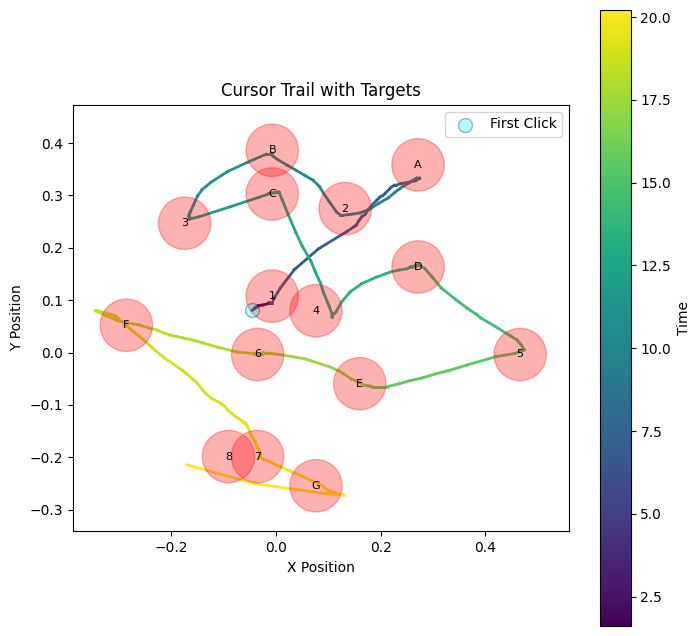

Trial ID: 0
Trial Type: TrialType.PART_A
Trial order: 16
Correct targets touches from analysis: 15.0
Wrong targets touches from analysis: 3.0


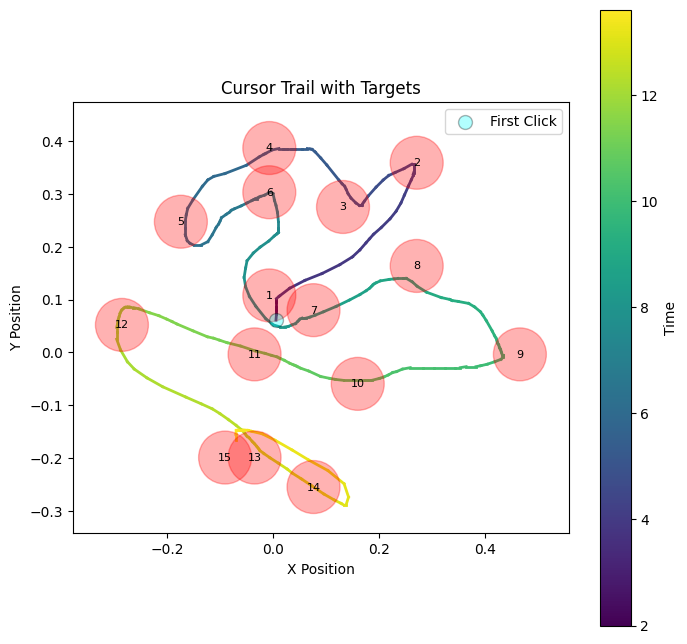

Trial ID: 0
Trial Type: TrialType.PART_B
Trial order: 9
Correct targets touches from analysis: 9.0
Wrong targets touches from analysis: 4.0


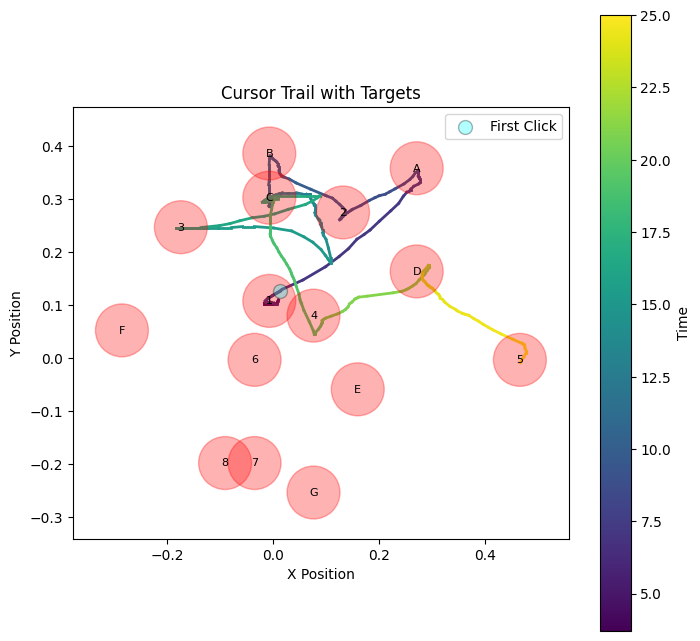

In [15]:

for subject_id in ["0063", "0091", "0022"]:
    subject_analysis = train_set[train_set['subject_id'] == int(subject_id)]
    subject = experiment.subjects[subject_id]
    for trial in sorted(subject.testing_trials, key=lambda x: x.id):
        print("Trial ID:", trial.id)
        print("Trial Type:", trial.trial_type)
        print("Trial order:", trial.order_of_appearance)
        print("Correct targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['correct_targets_touches'].values[0])
        print("Wrong targets touches from analysis:", subject_analysis[subject_analysis['trial_id'] == trial.id]['wrong_targets_touches'].values[0])
    
        plot_with_color(trial, subject.canvas_size, subject.target_radius)
        plt.show()
        break
